# Package

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter

In [18]:
def initialize_parameters(seed=7, num_agents=1000, m=3, penalty=0.5, cost_max=1.33, cost_points=10, epsilon=1e-1):
    np.random.seed(seed)
    type_dist = np.random.dirichlet(np.random.uniform(1, 2, m))
    payments, penalties = generate_payments_and_penalties(type_dist, penalty, m)
    cost_values = np.linspace(0, cost_max, cost_points)
    return num_agents, m, type_dist, payments, penalties, cost_values, epsilon

# Generate payments and penalties based on type distribution

In [7]:
# Generate payments and penalties based on type distribution
def generate_payments_and_penalties(type_dist, penalty, m):
    payments = np.zeros(m)
    cumulative = 0
    for i in range(m):
        cumulative += type_dist[i]
        payments[i] = 1 + cumulative / 2
    penalties = payments + penalty
    return payments, penalties

# valuation function

In [8]:
def valuation_function(i, k, payments):
    if k == i:
        return payments[i]
    elif k > i:
        return max(payments[i] - 0.2 * (k - i), 0.0)
    else:
        return max(payments[i] - 0.4 * (i - k), 0.0)

#Principal utility computation

In [9]:
def principal_utility(type_dist, audit_vector, cost, equilibrium_strategy, num_agents, payments, penalties):
    utility = 0
    for idx in range(len(type_dist)):
        reported_type = equilibrium_strategy[idx]
        utility += type_dist[idx] * (
            valuation_function(idx, reported_type, payments)
            - payments[reported_type]
            + audit_vector[reported_type] * (penalties[reported_type] - cost)
        )
    return utility * num_agents

# Determine equilibrium strategy for agents

In [11]:
def determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon):
    u_hat = np.max(payments - audit_vector * penalties)
    A_hat = np.where(payments - audit_vector * penalties >= u_hat - epsilon)[0]
    equilibrium_strategy = np.zeros(len(payments), int)
    for idx in range(len(payments)):
        truthful_util = payments[idx]
        equilibrium_strategy[idx] = idx if truthful_util >= u_hat - epsilon else np.min(A_hat)
    return equilibrium_strategy

In [12]:
def optimal_non_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon):
    best_utility = -np.inf
    optimal_audit_vector = np.zeros(m)
    for i in range(m - 1):
        for u in [payments[i] + epsilon, payments[i+1] - epsilon]:
            audit_vector = np.clip((payments - u) / penalties, 0, 1)
            eq_strategy = determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon)
            utility = principal_utility(type_dist, audit_vector, cost, eq_strategy, num_agents, payments, penalties)
            if utility > best_utility:
                best_utility = utility
                optimal_audit_vector = audit_vector.copy()
    return best_utility, optimal_audit_vector

In [13]:
def optimal_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents):
    epsilon = 0
    best_utility = -np.inf
    optimal_audit_vector = np.zeros(m)
    for i in range(m - 1):
        for u in [payments[i], payments[i + 1]]:
            audit_vector = np.clip((payments - u) / penalties, 0, 1)
            eq_strategy = determine_equilibrium_strategy(payments, penalties, audit_vector, epsilon)
            utility = principal_utility(type_dist, audit_vector, cost, eq_strategy, num_agents, payments, penalties)
            if utility > best_utility:
                best_utility = utility
                optimal_audit_vector = audit_vector.copy()
    return best_utility, optimal_audit_vector

In [14]:
def verify_assumptions(payments, penalties, cost, type_dist):
    A1 = np.all(cost <= penalties)
    A2 = np.all(np.diff(payments) / payments[:-1] >= np.diff(penalties) / penalties[:-1])
    A3 = np.all(np.diff(payments) >= 0)
    A4 = np.all(penalties >= payments)
    A5 = np.isclose(np.sum(type_dist), 1)
    return A1, A2, A3, A4, A5

Cost: 0.00, A1: ✔️, A2: ✔️, A3: ✔️, A4: ✔️, A5: ✔️
Cost: 0.15, A1: ✔️, A2: ✔️, A3: ✔️, A4: ✔️, A5: ✔️
Cost: 0.30, A1: ✔️, A2: ✔️, A3: ✔️, A4: ✔️, A5: ✔️
Cost: 0.44, A1: ✔️, A2: ✔️, A3: ✔️, A4: ✔️, A5: ✔️
Cost: 0.59, A1: ✔️, A2: ✔️, A3: ✔️, A4: ✔️, A5: ✔️
Cost: 0.74, A1: ✔️, A2: ✔️, A3: ✔️, A4: ✔️, A5: ✔️
Cost: 0.89, A1: ✔️, A2: ✔️, A3: ✔️, A4: ✔️, A5: ✔️
Cost: 1.03, A1: ✔️, A2: ✔️, A3: ✔️, A4: ✔️, A5: ✔️
Cost: 1.18, A1: ✔️, A2: ✔️, A3: ✔️, A4: ✔️, A5: ✔️
Cost: 1.33, A1: ✔️, A2: ✔️, A3: ✔️, A4: ✔️, A5: ✔️


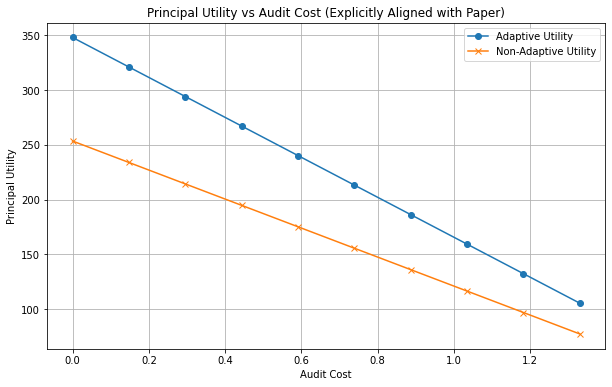

In [19]:
# Run complete simulations
def run_simulation():
    num_agents, m, type_dist, payments, penalties, cost_values, epsilon = initialize_parameters()
    utility_non_adaptive = []
    utility_adaptive = []
    
    for cost in cost_values:
        # Non-adaptive setting with epsilon perturbation
        na_utility, _ = optimal_non_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents, epsilon)
        utility_non_adaptive.append(na_utility)

        # Adaptive setting without epsilon perturbation
        ad_utility, _ = optimal_adaptive_policy(type_dist, payments, penalties, cost, m, num_agents)
        utility_adaptive.append(ad_utility)

        # Verify assumptions
        A1, A2, A3, A4, A5 = verify_assumptions(payments, penalties, cost, type_dist)
        print(f"Cost: {cost:.2f}, A1: {'✔️' if A1 else '❌'}, A2: {'✔️' if A2 else '❌'}, A3: {'✔️' if A3 else '❌'}, A4: {'✔️' if A4 else '❌'}, A5: {'✔️' if A5 else '❌'}")

    plot_results(cost_values, utility_adaptive, utility_non_adaptive)

# Plotting results explicitly
def plot_results(cost_values, adaptive_utility, non_adaptive_utility):
    plt.figure(figsize=(10, 6))
    plt.plot(cost_values, adaptive_utility, label='Adaptive Utility', marker='o')
    plt.plot(cost_values, non_adaptive_utility, label='Non-Adaptive Utility', marker='x')
    plt.xlabel('Audit Cost')
    plt.ylabel('Principal Utility')
    plt.title('Principal Utility vs Audit Cost (Explicitly Aligned with Paper)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Execute simulation
if __name__ == "__main__":
    run_simulation()